<a href="https://colab.research.google.com/github/kalexrt/hatespeech/blob/main/hatespeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data load

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/CollabData/hatedata/errortest.csv')

In [ ]:
# df.head()

In [ ]:
# df.tail()

## Preprocess data

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
texts = df['comment_text']
labels = df[df.columns[2:]].values

In [ ]:
MAX_FEATURES = 150000

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length = 1000,
                               output_mode ='int')

In [ ]:
vectorizer.adapt(texts.values)

In [ ]:
# vectorizer.get_vocabulary()

In [ ]:
vectorizer.text = vectorizer(texts.values)

In [ ]:
vectorizer.text

<tf.Tensor: shape=(159571, 1000), dtype=int64, numpy=
array([[  668,    79,     2, ...,     0,     0,     0],
       [  146, 15757,    52, ...,     0,     0,     0],
       [  407,   416,     4, ...,     0,     0,     0],
       ...,
       [28310,  6902,  4876, ...,     0,     0,     0],
       [    6,    11,   566, ...,     0,     0,     0],
       [    6,     4,   139, ...,     0,     0,     0]])>

**Data pipeline** -- map, cache, shuffle, batch, prefetch

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizer.text, labels))

In [ ]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #prevents bottlenecks

In [ ]:
# dataset

In [ ]:
# dataset.as_numpy_iterator().next()

In [ ]:
#splitting train and validation data
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.3))
# test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
# # preprocess test data
# # Read the test data
# df_test = pd.read_csv('/content/drive/My Drive/CollabData/hatedata/test.csv')

# # Extract text and labels
# labels_test = df_test[df_test.columns[2:]].values
# texts_test = df_test['comment_text']

# # Use the same vectorizer on the test data
# vectorized_texts_test = vectorizer(texts_test.values)

# # Create a separate Dataset for the test data
# dataset_test = tf.data.Dataset.from_tensor_slices((vectorized_texts_test, labels_test))
# dataset_test = dataset_test.cache()
# dataset_test = dataset_test.shuffle(160000)  # Adjust the shuffle size if needed
# dataset_test = dataset_test.batch(16)
# dataset_test = dataset_test.prefetch(8)

In [ ]:
# dataset_test.as_numpy_iterator().next()

In [ ]:
# df_test.head()

In [ ]:
train_generator = train.as_numpy_iterator()
train_generator.next()

(array([[32267,    11,    47, ...,     0,     0,     0],
        [    6,    10,   189, ...,     0,     0,     0],
        [ 2397,     5,   345, ...,     0,     0,     0],
        ...,
        [   25,     7,   257, ...,     0,     0,     0],
        [ 1993,   170,    12, ...,     0,     0,     0],
        [ 4731,  1487,   784, ...,     0,     0,     0]]),
 array([[1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]]))

##Seq Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2

dropout_rate = 0.01
l2_lambda = 0.01

In [ ]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(rate=dropout_rate))

model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(rate=dropout_rate))

model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(rate=dropout_rate))

model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          4800032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs = 1, validation_data = val)

6981/6981 [==============================] - 575s 81ms/step - loss: 0.0599 - val_loss: 0.0444


In [ ]:
history.history

{'loss': [0.05989725887775421], 'val_loss': [0.0444217324256897]}

In [ ]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

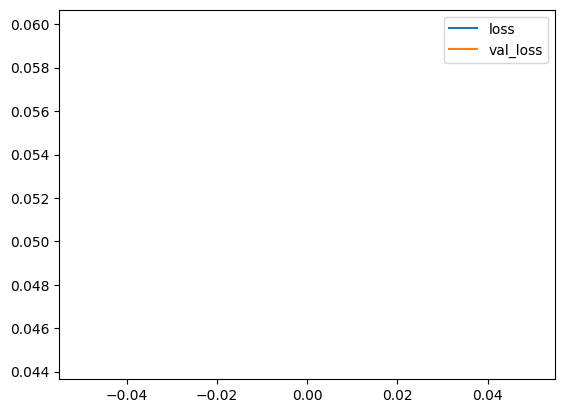

In [ ]:
d_f = pd.DataFrame(history.history)
plt.figure(figsize=(8,5))
d_f.plot()
plt.show()

##Prediction

In [ ]:
input_text = vectorizer("kill yourself")

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
model.predict(np.expand_dims(input_text,0))>0.5

1/1 [==============================] - 0s 37ms/step


array([[ True, False, False, False, False, False]])

In [ ]:
# batch_X, batch_y = test.as_numpy_iterator().next()

NameError: ignored

In [ ]:
# res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 37ms/step


In [ ]:
# from tensorflow.keras.models import load_model

# model.save('/content/drive/My Drive/CollabData/hatedata/model_20.h5')

In [ ]:
# model = load_model("...") #insert model path here

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/CollabData/hatedata/train.csv')

In [ ]:
X = test_df['comment_text']
Y = test_df[test_df.columns[2:].values]

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, Y))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(160000)
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(8)

In [ ]:
test = test_dataset.take(int(len(dataset)*.4))

In [ ]:
# for batch in test.as_numpy_iterator():

#     X_true, y_true = batch

#     yhat = model.predict(X_true)

#     y_true = y_true.flatten()
#     yhat = yhat.flatten()

#     pre.update_state(y_true, yhat)
#     re.update_state(y_true, yhat)
#     acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.0, Recall:0.0, Accuracy:0.0
